In [2]:
%pip uninstall sagemaker -y

Found existing installation: sagemaker 2.165.0
Uninstalling sagemaker-2.165.0:
  Successfully uninstalled sagemaker-2.165.0
Note: you may need to restart the kernel to use updated packages.


In [3]:
%pip install --upgrade sagemaker==2.132.0 --ignore-installed PyYAML

  Using cached sagemaker-2.132.0-py2.py3-none-any.whl
  Using cached PyYAML-6.0-cp37-cp37m-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_12_x86_64.manylinux2010_x86_64.whl (596 kB)
  Using cached attrs-22.2.0-py3-none-any.whl (60 kB)
  Using cached boto3-1.26.163-py3-none-any.whl (135 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl (57 kB)
  Using cached numpy-1.21.6-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (15.7 MB)
  Using cached protobuf-3.20.3-cp37-cp37m-manylinux_2_5_x86_64.manylinux1_x86_64.whl (1.0 MB)
  Using cached protobuf3_to_dict-0.1.5-py3-none-any.whl
  Using cached smdebug_rulesconfig-1.0.1-py2.py3-none-any.whl (20 kB)
  Using cached importlib_metadata-4.13.0-py3-none-any.whl (23 kB)
  Using cached packaging-23.1-py3-none-any.whl (48 kB)
  Using cached pandas-1.3.5-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (11.3 MB)
  Using cached pathos-0.3.0-py3-none-any.whl (79 kB)
  Using cached schema-0.7.5-py2.py3-none-any.whl (17 kB)
  U

In [4]:
import IPython
IPython.Application.instance().kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}

In [4]:
import time
import os
import json
import boto3
import numpy as np  
import pandas as pd 
import sagemaker

sagemaker.__version__

'2.132.0'

In [5]:
%pip install opencv-python torchvision facenet_pytorch torch gaze-tracking ffmpeg-python

  Using cached opencv_python-4.7.0.72-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (61.8 MB)
  Using cached torchvision-0.14.1-cp37-cp37m-manylinux1_x86_64.whl (24.2 MB)
  Using cached facenet_pytorch-2.5.3-py3-none-any.whl (1.9 MB)
  Using cached torch-1.13.1-cp37-cp37m-manylinux1_x86_64.whl (887.5 MB)
  Using cached gaze_tracking-0.0.1-py3-none-any.whl (1.3 kB)
  Using cached ffmpeg_python-0.2.0-py3-none-any.whl (25 kB)
  Using cached nvidia_cuda_runtime_cu11-11.7.99-py3-none-manylinux1_x86_64.whl (849 kB)
  Using cached nvidia_cudnn_cu11-8.5.0.96-2-py3-none-manylinux1_x86_64.whl (557.1 MB)
  Using cached nvidia_cublas_cu11-11.10.3.66-py3-none-manylinux1_x86_64.whl (317.1 MB)
  Using cached nvidia_cuda_nvrtc_cu11-11.7.99-2-py3-none-manylinux1_x86_64.whl (21.0 MB)
Note: you may need to restart the kernel to use updated packages.


In [6]:
# Get some variables you need to interact with SageMaker service
boto_session = boto3.Session()
region = boto_session.region_name
bucket_name = sagemaker.Session().default_bucket()
bucket_prefix = "emo-video/resnet"  
sm_session = sagemaker.Session()
sm_client = boto_session.client("sagemaker")
sm_role = sagemaker.get_execution_role()

sm = sm_session.sagemaker_client

initialized = True

print(sm_role)

arn:aws:iam::567821811420:role/service-role/AmazonSageMaker-ExecutionRole-20230619T084765


In [7]:
# Store some variables to keep the value between the notebooks
%store bucket_name
%store bucket_prefix
%store sm_role
%store region
%store initialized

Stored 'bucket_name' (str)
Stored 'bucket_prefix' (str)
Stored 'sm_role' (str)
Stored 'region' (str)
Stored 'initialized' (bool)


In [8]:
# Get and store domain ID - needed to some api calls etc.
NOTEBOOK_METADATA_FILE = "/opt/ml/metadata/resource-metadata.json"
domain_id = None

if os.path.exists(NOTEBOOK_METADATA_FILE):
    with open(NOTEBOOK_METADATA_FILE, "rb") as f:
        domain_id = json.loads(f.read()).get('DomainId')
        print(f"SageMaker domain id: {domain_id}")

%store domain_id

SageMaker domain id: d-ivd5gnez0yil
Stored 'domain_id' (str)


In [9]:
import numpy as np 
import json
import joblib
import sagemaker
import os
from time import gmtime, strftime, sleep
import random
from sklearn.metrics import roc_auc_score
from sagemaker.experiments.run import Run, load_run
import torch
import torch.utils.data
import torch.nn as nn

from torch import optim
from torchvision import models

import matplotlib.pyplot as plt
torch.__version__

'1.13.1+cu117'

In [11]:
# This cell should be tagged with `parameters` tag and will be overwritten if the notebook executed headlessly
file_source = "EFS"
file_name = "fer2013.csv"
input_path = "./data" 
output_path = "./models"

In [12]:
# If run the notebook as a job, non-interactivel or headlessly, the notebook cannot access the Studio EFS volume, download the dataset from S3 instead
# See the section "Run the notebook as a SageMaker job" for more details
if file_source != "EFS":
    session.download_data(
        path=os.path.join(input_path, ""), 
        bucket=bucket_name,
        key_prefix=f"{bucket_prefix}/input/{file_name}"
    )

In [13]:
df_data = pd.read_csv(os.path.join(input_path, file_name), sep=",")

pd.set_option("display.max_columns", 500)  # View all of the columns
df_data  # show first 5 and last 5 rows of the dataframe

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training
...,...,...,...
35882,6,50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...,PrivateTest
35883,3,178 174 172 173 181 188 191 194 196 199 200 20...,PrivateTest
35884,0,17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...,PrivateTest
35885,3,30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...,PrivateTest


In [14]:
experiment_name = f"emo-video-experiment-1"
%store experiment_name

Stored 'experiment_name' (str)


In [15]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [16]:
groups = [g for _, g in df_data.groupby('Usage')]
training_data = groups[2]
validation_data = groups[1]
testing_data = groups[0]

training_data = training_data.drop(['Usage'], axis=1)
validation_data = validation_data.drop(['Usage'], axis=1)
testing_data = testing_data.drop(['Usage'], axis=1)

print(f"Data shapes: train: {training_data.shape}, val: {validation_data.shape}, test: {testing_data.shape}")

Data shapes: train: (28709, 2), val: (3589, 2), test: (3589, 2)


In [17]:
# Save data to Studio filesystem
training_data.to_csv(os.path.join(output_path, "train.csv"), index=False, header=False)
validation_data.to_csv(os.path.join(output_path, "validation.csv"), index=False, header=False)
testing_data.to_csv(os.path.join(output_path, "test.csv"), index=False, header=False)

In [18]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")
label_names = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

def make_dataloader(data, batch_size, shuffle,* ,cut=None):
    
    if cut is not None:
        images, labels = data['pixels'][:cut], data['emotion'][:cut]
        print('cut loader created')
    else:
        images, labels = data['pixels'], data['emotion']
    
    
    images = np.array([np.fromstring(image, np.uint8, sep=' ') for image in images]) / 255.0 # normalizing data to be between 0 and 1
    images = torch.FloatTensor(images.reshape(images.shape[0], 1, 48, 48)).to(device) # 1 color channel, 48x48 images
    dataset = torch.utils.data.TensorDataset(images, torch.LongTensor(np.array(labels)).to(device))
    return torch.utils.data.DataLoader(dataset=dataset, batch_size=batch_size, shuffle=shuffle)

Device: cuda:0


In [19]:
train_loader = make_dataloader(training_data, 128, True)
valid_loader = make_dataloader(validation_data, 128, False)

In [20]:
%matplotlib inline

Fear


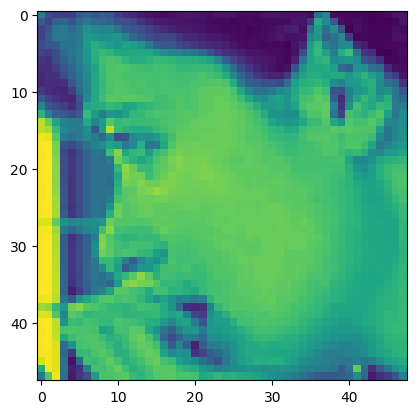

In [21]:
dataiter = iter(train_loader)
images, labels = next(dataiter)
print(label_names[labels[1]])
plt.imshow(images[3].view(48, 48).cpu());

In [50]:
run_suffix = strftime('%Y-%m-%M-%S', gmtime())

with Run(experiment_name='emo-video-data-processing',
         run_name=f"main-{run_suffix}",
         run_display_name="main",
         sagemaker_session=sm_session) as run:
    run.log_parameters(
        {
            "split": 'default'
        }
    )
    # Log input dataset metadata and output
    run.log_artifact(name="fer2013-dataset", value="./data/fer2013.csv", media_type="text/csv", is_output=False)
    run.log_artifact(name="train-csv", value="./data/train.csv", media_type="text/csv")
    run.log_artifact(name="validation-csv", value="./data/validation.csv", media_type="text/csv")
    run.log_artifact(name="test-csv", value="./data/test.csv", media_type="text/csv")

In [22]:
def adjust_model(model):
    model.conv1 = nn.Conv2d(1, 64, model.conv1.kernel_size, model.conv1.stride, model.conv1.padding, bias=False)
    model.fc = nn.Linear(model.fc.in_features, 7, bias=False)
    return model

In [23]:
def eval_model(model, data_loader, criterion):
    model.eval()
    with torch.no_grad():
        accuracy = 0
        loss = 0
        for data, labels in data_loader:
            output = model(data)
            _, preds = torch.max(output.data, 1)
            equals = (preds == labels).cpu()
            accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
            loss += criterion(output, labels).data.cpu()
        return accuracy/len(data_loader), loss/len(data_loader)
        
def train_model(model, criterion, optimizer, data_loader, eval_loader, *, epochs=3, print_debug=False):
    model = model.to(device)
    test_accuracy_history = []
    test_loss_history = []
    for epoch in range(epochs):
        if print_debug:
            print(f"Training epoch {epoch}")
        
        model.train()
        for data, labels in data_loader:
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
            
        accuracy, loss = eval_model(model, eval_loader, criterion)
        
        if print_debug:
            print(f"epoch: {epoch}, acc: {accuracy}, loss: {loss}")
            
        test_accuracy_history.append(accuracy)
        test_loss_history.append(loss)
        
    return test_accuracy_history, test_loss_history

In [24]:
criterion = nn.CrossEntropyLoss()
lrs = [0.1, 0.01, 0.005]
models_list = [adjust_model(models.resnet18()) for i in range(len(lrs))]
optimizers = [optim.SGD(models_list[i].parameters(), lr=lrs[i], momentum=0.9) for i in range(len(lrs))]

In [25]:
%pip install tensorboard

  Using cached tensorboard-2.11.2-py3-none-any.whl (6.0 MB)
  Using cached absl_py-1.4.0-py3-none-any.whl (126 kB)
  Using cached grpcio-1.56.0-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (5.2 MB)
  Using cached google_auth-2.21.0-py2.py3-none-any.whl (182 kB)
  Using cached google_auth_oauthlib-0.4.6-py2.py3-none-any.whl (18 kB)
  Using cached Markdown-3.4.3-py3-none-any.whl (93 kB)
  Using cached tensorboard_data_server-0.6.1-py3-none-manylinux2010_x86_64.whl (4.9 MB)
  Using cached tensorboard_plugin_wit-1.8.1-py3-none-any.whl (781 kB)
  Using cached cachetools-5.3.1-py3-none-any.whl (9.3 kB)
  Using cached pyasn1_modules-0.3.0-py2.py3-none-any.whl (181 kB)
  Using cached requests_oauthlib-1.3.1-py2.py3-none-any.whl (23 kB)
  Using cached oauthlib-3.2.2-py3-none-any.whl (151 kB)
Note: you may need to restart the kernel to use updated packages.


In [26]:
from torch.utils.tensorboard import SummaryWriter
%load_ext tensorboard

In [27]:
!rm -rf logs

In [32]:
writer = SummaryWriter(log_dir="logs")
writer.add_graph(models_list[1], images.to('cpu'))
writer.close()

In [45]:
!kill 103

In [51]:
%tensorboard --logdir logs

Reusing TensorBoard on port 6006 (pid 203), started 0:14:58 ago. (Use '!kill 203' to kill it.)

In [47]:
epochs = 5

In [48]:
for i in range(len(lrs)):
    lr = lrs[i]
    run_name = f"train-lr-{str(lr).replace('.','-')}-epochs-{epochs}"
    
    with Run(experiment_name=experiment_name,
                 run_name=run_name,
                 run_display_name=f"lr-{str(lr).replace('.','-')}-epochs-{epochs}",
                 sagemaker_session=sm_session) as run:
    
        accuracy, loss = train_model(models_list[i], criterion, optimizers[i], 
                                 train_loader, valid_loader, epochs=epochs, print_debug = True)
    
        run.log_parameters({"lr":lr, "epochs": epochs})
        run.log_metric(name="accuracy", value = accuracy[-1], step=epochs)
        run.log_metric(name="loss", value = loss[-1], step=epochs)    
    
        torch.save(accuracy, f'{output_path}/ResNet18_lr_{lr}_{epochs}_accuracy.pt')
        torch.save(loss, f'{output_path}/ResNet18_lr_{lr}_{epochs}_loss.pt') 
        torch.save(models_list[i], f'{output_path}/ResNet18_lr_{lr}_{epochs}_model.pt')

Training epoch 0
epoch: 0, acc: 0.4551724138958701, loss: 1.3497130870819092
Training epoch 1
epoch: 1, acc: 0.456950431240016, loss: 1.435526967048645
Training epoch 2
epoch: 2, acc: 0.48992456906828385, loss: 1.3705816268920898
Training epoch 3
epoch: 3, acc: 0.5300646552751804, loss: 1.281771183013916
Training epoch 4
epoch: 4, acc: 0.5423491381365677, loss: 1.2525829076766968
Training epoch 0
epoch: 0, acc: 0.45721982779174014, loss: 1.4181684255599976
Training epoch 1
epoch: 1, acc: 0.45867456906828385, loss: 1.4671059846878052
Training epoch 2
epoch: 2, acc: 0.44520474148207695, loss: 1.559312343597412
Training epoch 3
epoch: 3, acc: 0.47904094848139533, loss: 1.7324846982955933
Training epoch 4
epoch: 4, acc: 0.49181034493035286, loss: 1.5171836614608765
Training epoch 0
epoch: 0, acc: 0.4661099139986367, loss: 1.3951107263565063
Training epoch 1
epoch: 1, acc: 0.456950431240016, loss: 1.422205924987793
Training epoch 2
epoch: 2, acc: 0.4473599138958701, loss: 1.5351381301879883

### Create processing and training jobs

In [55]:
input_s3_url = sm_session.upload_data(
    path="data/fer2013.csv",
    bucket=bucket_name,
    key_prefix=f"{bucket_prefix}/input"
)

%store input_s3_url
input_s3_url

Stored 'input_s3_url' (str)


's3://sagemaker-eu-central-1-567821811420/emo-video/resnet/input/fer2013.csv'

In [56]:
!aws s3 ls {bucket_name}/{bucket_prefix} --recursive

2023-06-29 20:54:05  301072766 emo-video/resnet/input/fer2013.csv


In [58]:
%%writefile preprocessing.py

import pandas as pd
import numpy as np
import argparse
import os

def _parse_args():
    
    parser = argparse.ArgumentParser()
    # Data, model, and output directories
    # model_dir is always passed in from SageMaker. By default this is a S3 path under the default bucket.
    parser.add_argument('--filepath', type=str, default='/opt/ml/processing/input/')
    parser.add_argument('--filename', type=str, default='fer2013.csv')
    parser.add_argument('--outputpath', type=str, default='/opt/ml/processing/output/')
    
    return parser.parse_known_args()


if __name__=="__main__":
    # Process arguments
    args, _ = _parse_arg

    df_data = pd.read_csv(os.path.join(args.filepath, args.filename), sep=",")
    
    random.seed(0)
    np.random.seed(0)
    torch.manual_seed(0)
    torch.cuda.manual_seed(0)
    torch.backends.cudnn.deterministic = True

    groups = [g for _, g in df_data.groupby('Usage')]
    training_data = groups[2]
    validation_data = groups[1]
    testing_data = groups[0]

    training_data = training_data.drop(['Usage'], axis=1)
    validation_data = validation_data.drop(['Usage'], axis=1)
    testing_data = testing_data.drop(['Usage'], axis=1)

    print(f"Data shapes: train: {training_data.shape}, val: {validation_data.shape}, test: {testing_data.shape}")

    training_data.to_csv(os.path.join(args.outputpath, "train/train.csv"), index=False, header=False)
    validation_data.to_csv(os.path.join(args.outputpath, "validation/validation.csv"), index=False, header=False)
    testing_data.to_csv(os.path.join(args.outputpath, "test/test.csv"), index=False, header=False)
    
    # ?? Baseline data

#     device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
#     print(f"Device: {device}")
#     label_names = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

#     def make_dataloader(data, batch_size, shuffle,* ,cut=None):

#         if cut is not None:
#             images, labels = data['pixels'][:cut], data['emotion'][:cut]
#             print('cut loader created')
#         else:
#             images, labels = data['pixels'], data['emotion']


#         images = np.array([np.fromstring(image, np.uint8, sep=' ') for image in images]) / 255.0 # normalizing data to be between 0 and 1
#         images = torch.FloatTensor(images.reshape(images.shape[0], 1, 48, 48)).to(device) # 1 color channel, 48x48 images
#         dataset = torch.utils.data.TensorDataset(images, torch.LongTensor(np.array(labels)).to(device))
#         return torch.utils.data.DataLoader(dataset=dataset, batch_size=batch_size, shuffle=shuffle)

#     train_loader = make_dataloader(training_data, 128, True)
#     valid_loader = make_dataloader(validation_data, 128, False)

Overwriting preprocessing.py


In [59]:
train_s3_url = f"s3://{bucket_name}/{bucket_prefix}/train"
validation_s3_url = f"s3://{bucket_name}/{bucket_prefix}/validation"
test_s3_url = f"s3://{bucket_name}/{bucket_prefix}/test"
# baseline_s3_url = f"s3://{bucket_name}/{bucket_prefix}/baseline"

In [60]:
%store train_s3_url
%store validation_s3_url
%store test_s3_url
# %store baseline_s3_url

Stored 'train_s3_url' (str)
Stored 'validation_s3_url' (str)
Stored 'test_s3_url' (str)


In [61]:
framework_version = "0.23-1"
processing_instance_type = "ml.t3.large"
processing_instance_count = 1

In [62]:
run_suffix = strftime('%Y-%m-%M-%S', gmtime())
run_name = f"emo-video-container-processing-{run_suffix}"

with Run(experiment_name=experiment_name,
         run_name=run_name,
         run_display_name="container-processing",
         sagemaker_session=sm_session
        ) as run:
    run.log_parameters(
        {
            "split": 'default'
        }
    )
   
    experiment_config = run.experiment_config

In [64]:
from sagemaker.sklearn.processing import SKLearnProcessor
from sagemaker.processing import ProcessingInput, ProcessingOutput

In [65]:
sklearn_processor = SKLearnProcessor(
    framework_version=framework_version,
    role=sm_role,
    instance_type=processing_instance_type,
    instance_count=processing_instance_count, 
    base_job_name='emo-video-processing',
    sagemaker_session=sm_session,
)

INFO:sagemaker.image_uris:Defaulting to only available Python version: py3


In [66]:
processing_inputs = [
        ProcessingInput(
            source=input_s3_url, 
            destination="/opt/ml/processing/input",
            s3_input_mode="File",
            s3_data_distribution_type="ShardedByS3Key"
        )
    ]

processing_outputs = [
        ProcessingOutput(
            output_name="train_data", 
            source="/opt/ml/processing/output/train",
            destination=train_s3_url,
        ),
        ProcessingOutput(
            output_name="validation_data", 
            source="/opt/ml/processing/output/validation", 
            destination=validation_s3_url
        ),
        ProcessingOutput(
            output_name="test_data", 
            source="/opt/ml/processing/output/test", 
            destination=test_s3_url
        ),
        # ProcessingOutput(
        #     output_name="baseline_data", 
        #     source="/opt/ml/processing/output/baseline", 
        #     destination=baseline_s3_url
        # ),
    ]

In [ ]:
try:
    sklearn_processor.run(
        inputs=processing_inputs,
        outputs=processing_outputs,
        code='preprocessing.py',
        wait=True,
        experiment_config=experiment_config,
        # arguments = ['arg1', 'arg2'],
    )
except botocore.exceptions.ClientError as e:
    if e.response['Error']['Code'] == 'AccessDeniedException':
        print(f"Ignore AccessDeniedException: {e.response['Error']['Message']} because of the slow resource tag auto propagation")
    else:
        raise e

INFO:sagemaker:Creating processing-job with name emo-video-processing-2023-06-29-21-12-09-708


.